In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td

In [2]:
constant = td.TemperatureDependenceConstant(value=2)
linear = td.TemperatureDependenceLinear(ref_temp=300, coeff=0.01)
table = td.TemperatureDependenceTable(temp_points=[250,300,350], func_values=[4,2,5])

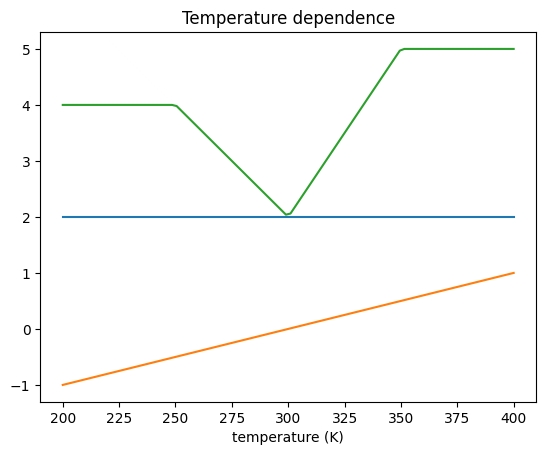

In [3]:
fig, ax = plt.subplots(1,1)
constant.plot(temperature=np.linspace(200,400,100), ax=ax)
linear.plot(temperature=np.linspace(200,400,100), ax=ax)
table.plot(temperature=np.linspace(200,400,100), ax=ax)
plt.show()

In [4]:
perm_change = td.TemperatureDependenceLinear(ref_temp=300, coeff=0.1)
cond_change = td.TemperatureDependenceConstant(value=0)
heat_spec = td.HeatSpecSolid(
    density=1,
    capacity=2,
    conductivity=3,
    permittivity_change=perm_change,
    conductivity_change=cond_change,
)

In [5]:
heat_spec.permittivity_change.sample(np.ones((1,2,3,4)))

array([[[[-29.9, -29.9, -29.9, -29.9],
         [-29.9, -29.9, -29.9, -29.9],
         [-29.9, -29.9, -29.9, -29.9]],

        [[-29.9, -29.9, -29.9, -29.9],
         [-29.9, -29.9, -29.9, -29.9],
         [-29.9, -29.9, -29.9, -29.9]]]])

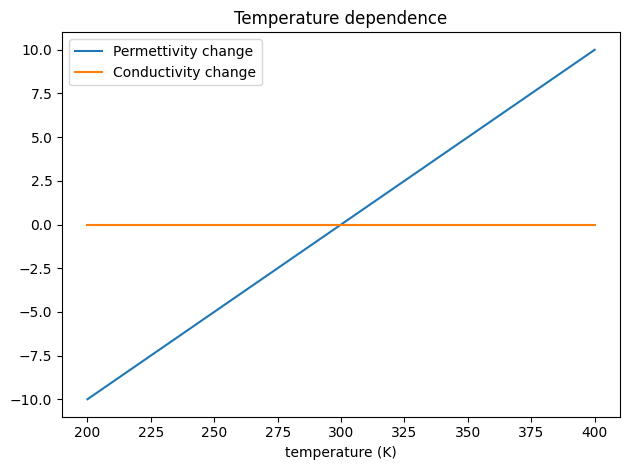

In [6]:
heat_spec.plot(temperature=np.linspace(200,400,100))
plt.show()

[21:09:59] WARNING: No sources in simulation.                                                     ]8;id=625400;file:///home/daniil/Flexcompute/Code/core/active/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=271942;file:///home/daniil/Flexcompute/Code/core/active/tidy3d_frontend/tidy3d/components/simulation.py#584\584]8;;\

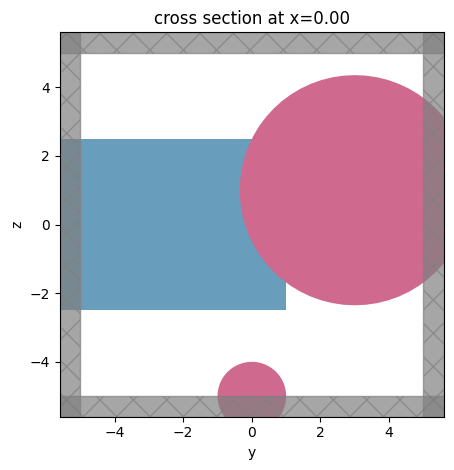

In [66]:
medium = td.Medium(
    permittivity=5,
    conductivity=0,
    heat_spec=heat_spec,
    name="med1",
)

medium2 = td.Medium(
    permittivity=7,
    conductivity=0,
    heat_spec=heat_spec,
    name="med2",
)

medium3 = td.Medium(
    permittivity=6,
    conductivity=0,
    heat_spec=heat_spec,
    name="med3",
)



box = td.Structure(
    geometry=td.Box(center=(0,-3,0), size=(5,8,5)),
    medium=medium,
    name="box1",
)

box2 = td.Structure(
    geometry=td.Sphere(center=(1,3,1), radius=3.5),
    medium=medium2,
    name="box2",
)    

box3 = td.Structure(
    geometry=td.Sphere(center=(0,0,-5), radius=1),
    medium=medium2,
    name="box3",
)    


sim = td.Simulation(
    medium=medium3,
    center=[0]*3,
    size=[10]*3,
    grid_spec=td.GridSpec.uniform(dl=0.05),
    structures=[box, box2, box3],
    run_time=1e-20,
)
sim.plot(x=0)
plt.show()

In [67]:
bc1 = td.HeatBoundaryPlacementStructure(structure="box1", bc=td.HeatBoundaryTemperature(temperature=300))
bc2 = td.HeatBoundaryPlacementStructure(structure="box2", bc=td.HeatBoundaryTemperature(temperature=400))
bc3 = td.HeatBoundaryPlacementStructureSimulation(structure="box2", bc=td.HeatBoundaryTemperature(temperature=400))
bc4 = td.HeatBoundaryPlacementSimulation(bc=td.HeatBoundaryTemperature(temperature=500))
bc5 = td.HeatBoundaryPlacementStructureStructure(structures=("box1", "box2"), bc=td.HeatBoundaryTemperature(temperature=400))
bc6 = td.HeatBoundaryPlacementStructureStructure(structures=("box2", None), bc=td.HeatBoundaryTemperature(temperature=400))
bc7 = td.HeatBoundaryPlacementMediumMedium(mediums=("med3", "med2"), bc=td.HeatBoundaryTemperature(temperature=400))
bc8 = td.HeatBoundaryPlacementMediumMedium(mediums=("med1", "med3"), bc=td.HeatBoundaryTemperature(temperature=400))
heat_sim = td.HeatSimulation(simulation=sim, boundary_conditions=[bc1, bc3, bc4, bc5, bc7])

[]
[]
[(HeatBoundaryPlacementStructureStructure(bc=HeatBoundaryTemperature(type='HeatBoundaryTemperature', temperature=400.0), type='HeatBoundaryPlacementStructureStructure', structures=('box1', 'box2')), 'box2', <LINESTRING (5 -1.688, 4.863 -1.789, 4.581 -1.958, 4.284 -2.099, 3.974 -2.21...>, (-0.3541019662496847, -2.3541019662496847, 5.0, 4.354101966249685), False)]
[(HeatBoundaryPlacementStructureStructure(bc=HeatBoundaryTemperature(type='HeatBoundaryTemperature', temperature=400.0), type='HeatBoundaryPlacementStructureStructure', structures=('box1', 'box2')), 'box2', <LINESTRING (1 -1.688, 0.872 -1.593, 0.628 -1.372, 0.407 -1.128, 0.211 -0.86...>, (-5.0, -2.5, 1.0, 2.5), True), (HeatBoundaryPlacementStructureStructure(bc=HeatBoundaryTemperature(type='HeatBoundaryTemperature', temperature=400.0), type='HeatBoundaryPlacementStructureStructure', structures=('box1', 'box2')), 'box1', <LINESTRING (-5 2.5, 1 2.5, 1 -2.5, -5 -2.5)>, (-5.0, -2.5, 1.0, 2.5), False)]


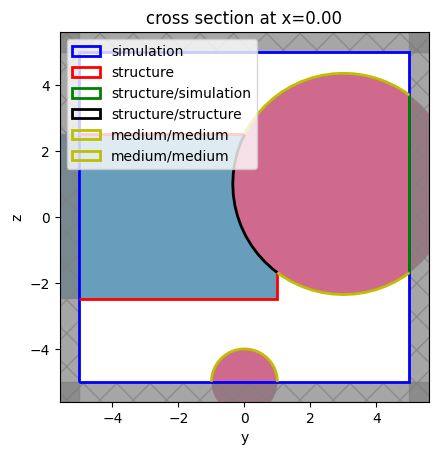

In [68]:
from tidy3d import HeatBoundaryPlacementStructure, HeatBoundaryPlacementSimulation, HeatBoundaryPlacementStructureSimulation, HeatBoundaryPlacementStructureStructure, HeatBoundaryPlacementMediumMedium
structures = heat_sim.simulation.structures
structures = [heat_sim.simulation.background_structure.updated_copy(name="back", geometry=heat_sim.simulation.bounding_box)] + list(structures)

plane = td.Box(center=(0,0,0), size=(0,20,20))

shapes = []
named_shapes = {}
for structure in structures:

    # get list of Shapely shapes that intersect at the plane
    shapes_plane = structure.geometry.intersections_2dbox(plane)

    # Append each of them and their medium information to the list of shapes
    for shape in shapes_plane:
        shapes.append((structure.name, shape, shape.bounds))

    # also keep track of named structures
    if structure.name:
        named_shapes[structure.name] = shapes_plane

sim_bc = False
# get potential boundaries
bcs_present = {}
for bc in heat_sim.boundary_conditions:
    if isinstance(bc, (HeatBoundaryPlacementStructure, HeatBoundaryPlacementStructureSimulation)) and bc.structure in named_shapes:
        if bc.structure in bcs_present:
            bcs_present[bc.structure] += [bc]
        else:
            bcs_present[bc.structure] = [bc]
            
    if isinstance(bc, HeatBoundaryPlacementStructureStructure):
        for structure in bc.structures:
            if structure in named_shapes:
                if structure in bcs_present:
                    bcs_present[structure] += [bc]
                else:
                    bcs_present[structure] = [bc]
            
    if isinstance(bc, HeatBoundaryPlacementSimulation):
        bcs_present["back"] = [bc]

background_shapes = []
boundaries = []

if sim_bc:
    boundaries
                
for name, shape, bounds in shapes:

    minx, miny, maxx, maxy = bounds

    # intersect existing boundaries
    for index, (_bc, _name, _bdry, _bounds) in enumerate(boundaries):
        
        # simulation bc is overriden only by HeatBoundaryPlacementStructureSimulation
        if isinstance(_bc, HeatBoundaryPlacementSimulation):
            if name not in bcs_present:
                continue
            if any([not isinstance(bc, HeatBoundaryPlacementStructureSimulation) for bc in bcs_present[name]]):
                continue

        _minx, _miny, _maxx, _maxy = _bounds

        # do a bounding box check to see if any intersection to do anything about
        if minx > _maxx or _minx > maxx or miny > _maxy or _miny > maxy:
            continue

        # look more closely to see if intersected.
        if _bdry.is_empty or not shape.intersects(_bdry):
            continue

        diff_shape = _bdry - shape
        
        boundaries[index] = (_bc, _name, diff_shape, diff_shape.bounds)

    # create new boundary
    if name in bcs_present:
        for bc in bcs_present[name]:
            
            if isinstance(bc, HeatBoundaryPlacementStructure):
                bdry = shape.exterior
                bdry = bdry.intersection(shapes[0][1])
                boundaries.append((bc, name, bdry, bdry.bounds))
                
            if isinstance(bc, HeatBoundaryPlacementSimulation):
                boundaries.append((bc, name, shape.exterior, shape.exterior.bounds))
                
            if isinstance(bc, HeatBoundaryPlacementStructureSimulation):
                bdry = shapes[0][1].exterior
                bdry = bdry.intersection(shape)
                boundaries.append((bc, name, bdry, bdry.bounds))

boundaries_reverse = []


for name, shape, bounds in shapes[:0:-1]:

    minx, miny, maxx, maxy = bounds

    # intersect existing boundaries
    print(boundaries_reverse)
    for index, (_bc, _name, _bdry, _bounds, _completed) in enumerate(boundaries_reverse):
        
        if not _completed:

            _minx, _miny, _maxx, _maxy = _bounds

            # do a bounding box check to see if any intersection to do anything about
            if minx > _maxx or _minx > maxx or miny > _maxy or _miny > maxy:
                continue

            # look more closely to see if intersected.
            if _bdry.is_empty or not shape.intersects(_bdry):
                continue

            if name in _bc.structures:
                new_bdry = _bdry.intersection(shape)
                boundaries_reverse[index] = (_bc, _name, new_bdry, diff_shape.bounds, True)
            else:
                new_bdry = _bdry - shape
                boundaries_reverse[index] = (_bc, _name, new_bdry, diff_shape.bounds, _completed)

    # create new boundary
    if name in bcs_present:
        for bc in bcs_present[name]:
            if isinstance(bc, HeatBoundaryPlacementStructureStructure):
                bdry = shape.exterior
                bdry = bdry.intersection(shapes[0][1])
                boundaries_reverse.append((bc, name, bdry, bdry.bounds, False))

                
                
named_shapes = {}                
shapes = []
for structure in structures:

    # get list of Shapely shapes that intersect at the plane
    shapes_plane = structure.geometry.intersections_2dbox(plane)

    # Append each of them and their medium information to the list of shapes
    for shape in shapes_plane:
        shapes.append((structure.medium, shape, shape.bounds))

    # also keep track of named structures
    if structure.medium.name:
        named_shapes[structure.medium.name] = shapes_plane
                
# get potential boundaries
bcs_med_present = {}
for bc in heat_sim.boundary_conditions:
            
    if isinstance(bc, HeatBoundaryPlacementMediumMedium):
        for med in bc.mediums:
            if med in named_shapes:
                if med in bcs_med_present:
                    bcs_med_present[med] += [bc]
                else:
                    bcs_med_present[med] = [bc]
        
boundaries_med = []
background_shapes = []
for medium, shape, bounds in shapes:

    minx, miny, maxx, maxy = bounds
    
    # subtract existing boundaries
    for index, (_bc, _bdry, _bounds) in enumerate(boundaries_med):

        _minx, _miny, _maxx, _maxy = _bounds

        # do a bounding box check to see if any intersection to do anything about
        if minx > _maxx or _minx > maxx or miny > _maxy or _miny > maxy:
            continue

        # look more closely to see if intersected.
        if _shape.is_empty or not shape.intersects(_shape):
            continue

        diff_shape = _bdry - shape
        
        # remove intersection from boundary
        if len(diff_shape.bounds) > 0:
            boundaries_med[index] = (_bc, diff_shape, diff_shape.bounds)
        
    
    # cut or merge background shapes and create new boundaries if needed

    # loop through background_shapes (note: all background are non-intersecting or merged)
    for index, (_medium, _shape, _bounds) in enumerate(background_shapes):

        _minx, _miny, _maxx, _maxy = _bounds

        # do a bounding box check to see if any intersection to do anything about
        if minx > _maxx or _minx > maxx or miny > _maxy or _miny > maxy:
            continue

        # look more closely to see if intersected.
        if _shape.is_empty or not shape.intersects(_shape):
            continue

        diff_shape = _shape - shape

        # different medium, remove intersection from background shape
        if medium != _medium and len(diff_shape.bounds) > 0:
            background_shapes[index] = (_medium, diff_shape, diff_shape.bounds)
            
            # create new boundaries
            if medium.name in bcs_med_present:
                for bc in bcs_med_present[medium.name]:
                    if _medium.name in bc.mediums:
                        bdry = shape.exterior.intersection(_shape)
                        boundaries_med.append((bc, bdry, bdry.bounds))

        # same medium, add diff shape to this shape and mark background shape for removal
        elif medium.name in bcs_med_present:
            shape = shape | diff_shape
            background_shapes[index] = None

    # after doing this with all background shapes, add this shape to the background
    if medium.name in bcs_med_present:
        background_shapes.append((medium, shape, shape.bounds))

    # remove any existing background shapes that have been marked as 'None'
    background_shapes = [b for b in background_shapes if b is not None]

# filter out any remaining None or empty shapes (shapes with area completely removed)
# return [(medium, shape) for (medium, shape, _) in background_shapes if shape]


print(boundaries_reverse)

fig, ax = plt.subplots(1,1)
heat_sim.simulation.plot(x=0, ax=ax)
                                           
from shapely.plotting import plot_line    
for bc, _, b, _ in boundaries:
    if isinstance(bc, HeatBoundaryPlacementStructure):
        color='r'
        label="structure"
    if isinstance(bc, HeatBoundaryPlacementSimulation):
        color='b'
        label="simulation"
    if isinstance(bc, HeatBoundaryPlacementStructureSimulation):
        color='g'
        label="structure/simulation"
    plot_line(b, color=color, ax=ax, label=label, add_points=False)
    
for bc, _, b, _, completed in boundaries_reverse:
    if completed:
        plot_line(b, color="k", ax=ax, label="structure/structure", add_points=False)
    if not bc.structures[1]:
        plot_line(b, color="k", ax=ax)

for bc, b, _ in boundaries_med:
    plot_line(b, color="y", ax=ax, label="medium/medium", add_points=False)
    
plt.legend()
plt.show()

In [25]:
nx, ny, nz = 92, 36, 54
x = np.linspace(-5, 5, nx)
y = np.linspace(-5, 5, ny)
z = np.linspace(-5, 5, nz)
T = np.random.default_rng().uniform(300, 350, (nx, ny, nz, 1))
# T = 305*np.ones((nx, ny, nz, 1))
coords = dict(x=x, y=y, z=z, t=[0])
temperature_field = td.ScalarFieldTimeDataArray(T, coords=coords)

In [26]:
temperature_field.interp(x=x,y=y,z=z)

<xarray.ScalarFieldTimeDataArray (x: 92, y: 36, z: 54, t: 1)>
array([[[[309.19124344],
         [309.77178407],
         [339.86227086],
         ...,
         [333.05873348],
         [308.80257963],
         [333.37464351]],

        [[336.64783358],
         [337.19876249],
         [347.49585464],
         ...,
         [347.01211855],
         [343.72129542],
         [346.00599112]],

        [[348.89536807],
         [303.65028229],
         [323.25083535],
         ...,
...
         ...,
         [315.53715032],
         [309.05818477],
         [300.27749661]],

        [[332.7673255 ],
         [300.11393196],
         [314.64452443],
         ...,
         [324.07584947],
         [312.80992837],
         [343.84690451]],

        [[340.34839412],
         [307.93496448],
         [347.14598334],
         ...,
         [324.78213928],
         [301.0040561 ],
         [303.86319163]]]])
Coordinates:
  * t        (t) int64 0
  * x        (x) float64 -5.0 -4.89 -4.78 -4.67 -4.56 ... 4.67 4.78 4.89 5.0
  * y        (y) float64 -5.0 -4.714 -4.429 -4.143 ... 4.143 4.429 4.714 5.0
  * z        (z) float64 -5.0 -4.811 -4.623 -4.434 ... 4.434 4.623 4.811 5.0

In [27]:
heat_sim_data = td.HeatSimulationData(
    heat_simulation=heat_sim,
    temperature_data=temperature_field,
)

In [28]:
new_sim = heat_sim_data.apply_heat_to_sim()

[15:07:12] WARNING: No sources in simulation.                                                     ]8;id=525089;file:///home/daniil/Flexcompute/Code/core/active/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=400709;file:///home/daniil/Flexcompute/Code/core/active/tidy3d_frontend/tidy3d/components/simulation.py#584\584]8;;\

In [29]:
new_sim.structures

(Structure(geometry=Box(type='Box', center=(0.0, -3.0, 0.0), size=(5.0, 8.0, 5.0)), name='box1', type='Structure', medium=CustomMedium(name=None, frequency_range=None, heat_spec=None, type='CustomMedium', eps_dataset=PermittivityDataset(type='PermittivityDataset', eps_xx=<xarray.ScalarFieldDataArray (x: 101, y: 133, z: 101, f: 1)>
 array([[[[       nan+0.j],
          [       nan+0.j],
          [       nan+0.j],
          ...,
          [       nan+0.j],
          [       nan+0.j],
          [       nan+0.j]],
 
         [[       nan+0.j],
          [       nan+0.j],
          [       nan+0.j],
          ...,
          [       nan+0.j],
          [       nan+0.j],
          [       nan+0.j]],
 
         [[       nan+0.j],
          [       nan+0.j],
          [       nan+0.j],
          ...,
 ...
          ...,
          [7.89008236+0.j],
          [7.70962589+0.j],
          [7.52916942+0.j]],
 
         [[7.43032548+0.j],
          [7.33263431+0.j],
          [7.23494313+0.j],
     

<Axes: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

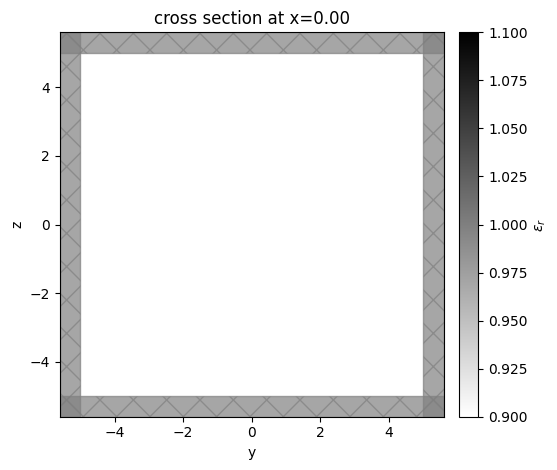

In [30]:
new_sim.plot_eps(x=0)